# Covid-19 Effect on Air Pollution

* The main purpose of this study is correctly predicting the countries/cities air pollution change with the machine learning algorithms such as XGBoost, Random Forest, K-Nearest Neighbor.

In [1]:
# General Libraries for Data Analysis and Visualization
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Statistics
import statsmodels.stats.api as sms

# Classification
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Standardization
from sklearn.preprocessing import StandardScaler

# Evaluation Metrics 
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score, roc_auc_score, roc_curve, auc, plot_roc_curve
# Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# Load data set
data = pd.read_csv("covid_data.csv")
data.head()

,Country,City,Country_Population,Total_Day_Lockdown,Avg_Pollution_2020,Avg_Pollution_2019,Development,Total_Case,Total_Death,Latitude,Longitude,Change
0,United Arab Emirates,Dubai,9890400,23,86.0,95,1,22627,214,23.424076,53.847818,1
1,Argentina,Buenos Aires,45195777,60,35.9,35,0,7792,363,-38.416097,-63.616672,0
2,Austria,Vienna,9006400,29,44.0,50,1,16140,628,47.516231,14.550072,1
3,Australia,Melbourne,25499881,56,31.0,28,1,7036,98,-25.274398,133.775136,0
4,Bangladesh,Dhaka,25499881,31,175.0,210,0,7036,98,23.684994,90.356331,1


* **Country:** name of the countries
* **City:** name of the city
* **Total_Day_Lockdown:** how many day lockdown applied to the country
* **Avg_Pollution_2020:** average air pollution level for the specific time periods in 2020
* **Avg_Pollution_2019:** average air pollution level for the specific time periods in 2019
* **Development:** if the country developed according to the World Bank GDP per capita (if it is above the 12000$ threshold level), 1. Otherwise 0.
* **Total_Case:** total number of Covid-19 cases until May 17, 2020
* **Total_Death:** total number of death because of Covid-19 until May 17,2020
* **Latitude:** latitiude of the country
* **Longitude:** longitude of the country
* **Change:** if there is a decrease in the air pollution level in 2020 compared to 2019, 1. Otherwise, 0. 

## Descriptive Statistics

In [3]:
data.shape

(47, 12)

* There are 47 observation and 12 attributes in the dataset.

In [4]:
data.isnull().values.any()

False

* There is no mising value in the dataset.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             47 non-null     object 
 1   City                47 non-null     object 
 2   Country_Population  47 non-null     int64  
 3   Total_Day_Lockdown  47 non-null     int64  
 4   Avg_Pollution_2020  47 non-null     float64
 5   Avg_Pollution_2019  47 non-null     int64  
 6   Development         47 non-null     int64  
 7   Total_Case          47 non-null     int64  
 8   Total_Death         47 non-null     int64  
 9   Latitude            47 non-null     float64
 10  Longitude           47 non-null     float64
 11  Change              47 non-null     int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 4.5+ KB


- There are two categorical variables in the dataset.

- There are 10 numerical attributes.  

In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Country_Population,47.00,101724795.60,286095427.06,2722291.00,6369824.50,19116209.00,55672356.00,1439323774.00
Total_Day_Lockdown,47.00,41.28,16.55,7.00,29.50,43.00,55.50,77.00
Avg_Pollution_2020,47.00,61.04,37.24,2.00,38.00,44.00,82.50,175.00
Avg_Pollution_2019,47.00,66.60,45.32,3.00,39.00,53.00,75.00,217.00
Development,47.00,0.62,0.49,0.00,0.00,1.00,1.00,1.00
Total_Case,47.00,82515.19,220366.27,0.00,4897.50,16140.00,69516.50,1467884.00
Total_Death,47.00,5941.15,15064.54,0.00,102.50,497.00,2780.00,88754.00
Latitude,47.00,30.56,27.45,-40.90,22.01,39.40,49.24,61.92
Longitude,47.00,21.32,60.14,-95.71,-0.89,15.47,50.66,174.89
Change,47.00,0.68,0.47,0.00,0.00,1.00,1.00,1.00


- All variables have different mean and standard deviation value, each of the attributes have dfferent scale.

- In average this year PM2.5 level is lower than the last year. 
- 61% of the countries are developed according to their Gdp per capita.
- PM2.5 level  decreased for the 68% of the cities.

#### Worldwide Cases and Deaths 


- In this study one major cities of each 47 countries is taken, their PM2.5 levels are compared with 2020 and 2019 in the same period.

- In the belove map, countries (which was selected in this study),  total number of confirmed cases and total number of deaths can be seen (as of 17th May 2020).

In [18]:
# World Map
def covid19_world_map(data, country_names, numerical_attribute_1, numerical_attribute_2, longitude_attribute, latitude_attribute):
    
    """Return the world wide map of Covid-19 cases and deaths for the countries."""
    
    world_map = folium.Map(location=[0, 0], 
                           tiles='cartodbpositron',
                           min_zoom=1, 
                           max_zoom=4, 
                           zoom_start=1)

    for i in range(0, len(data)):
        folium.Circle(location=[data.iloc[i][latitude_attribute], data.iloc[i][longitude_attribute]],
                      color='crimson', fill='crimson',
                      tooltip =   '<li><bold>Country : ' 
                      + str(data.iloc[i][country_names]) 
                      + '<li><bold>Confirmed Cases : '
                      + str(data.iloc[i][numerical_attribute_1])
                      + '<li><bold>Deaths : '+str(data.iloc[i][numerical_attribute_2]),
                      radius=int(data.iloc[i][numerical_attribute_1])**0.5).add_to(world_map)
    return world_map

covid19_world_map(data,'Country', 'Total_Case', 'Total_Death', 'Longitude', 'Latitude')

## Descriptive Statistics of Target Variable

In [8]:
data["Change"].describe()

count   47.00
mean     0.68
std      0.47
min      0.00
25%      0.00
50%      1.00
75%      1.00
max      1.00
Name: Change, dtype: float64

Text(0.5, 1.0, 'Positive Change / No Change')

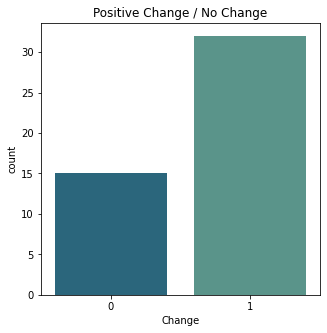

In [54]:
figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
chart = sns.countplot(x='Change', data=data, palette="gnuplot2")
chart.set_title('Positive Change / No Change')
    


* In this graph it can be seen that total number of Class 1's is much larger than total number  Class 0's. Nearly 68% of the cities has been affected positively and 32% of the cities has been faced with negative change or stay same in terms of PM2.5 levels.


In [19]:
# Change attribute derived from the Avg_Pollution_2020 and Avg_Pollution_2019 atributes. 
data1 = data.copy()
data1.drop(columns=["Country","City", "Avg_Pollution_2020","Avg_Pollution_2019", "Longitude", "Latitude"], inplace=True) 

In [20]:
#Outlier Detection
def print_outliers(data):
    
    """Return the number of outliers for each feature in the dataframe."""
    
    for column in data.columns:
        if column=="Id":
            continue
            
        quantiles=data[column].quantile(q=[0.25,0.50,0.75]).values
        q1=quantiles[0]
        q2=quantiles[1]
        q3=quantiles[2]
        iqr=q3-q1   
        lower_limit =  q1- 1.5*iqr
        upper_limit =  q3 + 1.5*iqr
        outliers=data[(data[column] < lower_limit) | (data[column] >  upper_limit)][column]
        
        print("number of outliers in {:10s} :\t{}\t({:.2%})".format(column, len(outliers), len(outliers)/len(data[column])))


In [21]:
print_outliers(data1)

number of outliers in Country_Population :	6	(12.77%)
number of outliers in Total_Day_Lockdown :	0	(0.00%)
number of outliers in Development :	0	(0.00%)
number of outliers in Total_Case :	7	(14.89%)
number of outliers in Total_Death :	8	(17.02%)
number of outliers in Change     :	0	(0.00%)


* There are outliers in the *Country_Population, Avg_Pollution_2020, Avg_Pollution_2019, Total_Case, Total_Death*. 

In [50]:
# 'Change' variable is the target.
# Split dataset to X and y sets. X is for independent attribute and y for target attribute.
y = data1.iloc[:,-1:]
X = data1.iloc[:,:-1]

### Standardization

When independent variables in training data are measured in different units, it is important to standardize variables before applying algorithms because one variable may dominate all the others. Since in the dataset all variables are in different scale, before applying any algorithm to the data, explanatory variables are standardized. 

In [51]:
def standardize(data):
    
    """Return the standardized dataframe."""
    
    data1 = data.copy()
    data1 = StandardScaler().fit_transform(data1)
    data1 = pd.DataFrame(data1, columns = data.columns)
    
    return data1

X = standardize(X)

## Train Test Split

In all analysis data set is divided into training data and test data. 30% of the data is used for testing, remaining 70% is used for training. Training set contains 35 observations and test set contains 15 observations.

In [52]:
X_training, X_test, y_training, y_test = train_test_split(X, 
                                                          y, 
                                                          test_size = 0.3, 
                                                        random_state = 123)

## Models


- In this section Logistic Regression, Support Vector Machine, Random Forest and K-Nearest Neigbors algorithms is applied to the dataset. Their hyperparameters will be tuned, after tuning general performance of the model will be calculated with repeated 5-Fold cross validation.



 



### Hyperparameter Optimization


* A hyperparameter is external to the model and the value of it cannot be estimated from data. It affects the model performance and because of that hyperparameter tuning is important for all algorithms. 


* In this study, for each of the algorithms best hyperparameters are found with Grid Search Cross Validation. Grid-searching is a method that searching for best combination of hyperparameters. 


* In Scikitlearn, there is a *GridSearchCV*. Grid Search CV tries all possible parameter combinations which are determined by the user and find the best parameter setting for a specificed scoring method. 

* For this study, hypothetical set for each the hyperparameter are defined first, and best combination of hyperparameters are selected by GridSearchCV() method with Stratified 5-fold cross validation on training dataset. 

**Note:** Stratified Kfold CV i a cross validiation technique which is usd when data is imbalanced. It protect the distribution of target in the original data in each fold. 


In [119]:
def hyperparameter_tuning(X, y, estimator, parameters, n_splits):
    
    
    """Return the best parameters using Grid Search method with Stratified Kfold CV."""
    cross_validation_method = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

    grid_search_model = GridSearchCV(estimator=estimator, 
                                     param_grid=parameters, 
                                     cv=cross_validation_method,
                                     scoring='f1',
                                     n_jobs=-1,
                                     verbose=2)
    
    grid_search_model.fit(X, y);
    
    return grid_search_model.best_params_

In [111]:
def fit_predict(X, y, classifier):
    
    """Fit model and predict the target, return predicted target."""
    
    tuned_model = classifier
    tuned_model.fit(X, y)
    y_predict_test = tuned_model.predict(X)
    
    return y_predict_test

In [112]:
def model_evaluate(classifier, X, y_true, y_pred):
    
    """Evaluate the perofrmance of model using confusion matrix, balanced accuracy and F1 score."""
    
    confusion_matrix_ = confusion_matrix(y_true, y_pred)
    sns.heatmap(confusion_matrix_, annot=True, fmt="d", cmap="Blues")
    print("Balanced accuracy score: ", "{:.2f}".format(balanced_accuracy_score(y_true, y_pred)), 
          "\nF1-score: ", "{:.2f}".format(f1_score(y_true, y_pred)),
          "\n\nConfusion Matrix: ")
    

In [113]:
def plot_roc_curve(y_true, y_pred, title):
    
    """Plot the Receiver Operating Characteristic Curve and calculate Area Under Curve (AUC)."""

    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.title(title)
    plt.plot(fpr, tpr, 'b', label ='AUC = %0.2f' % roc_auc)
    plt.legend(loc ='lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [114]:
def model_general_performance(classifier, title):
    
    # Evaluate the performance of the model with whole data, using f1-score.
    scoring = {'F1-score': 'f1', 'Balanced Accuracy': 'balanced_accuracy'}
    cv_method = StratifiedK(n_splits=5, random_state=0)
    cv_result = cross_val_score(tuned_model, X=X, y=y, cv=cv_method, scoring=scoring)
    
    print("F1 Score of ", title, ": %0.2f "  % f1_score.mean(), "\nConfidence Interval: ", "%0.2f, %0.2f" % sms.DescrStatsW(f1_score).tconfint_mean(),
         print("Balanced Accuracy of ", title, ": %0.2f "  % balanced_accuracy_score.mean(), "\nConfidence Interval: ", "%0.2f, %0.2f" % sms.DescrStatsW(f1_score).tconfint_mean()))
    
    return cv_result

## 1. XGBoost


- XGBoost is one of the most popular machine learning algorithm.


- It is an improved version Gradient Boosting Machine. 


- It is has both algoritmic and system optimization. These are




    1. Approximate greedy algorithm to increase the speed.
    2. Regularized objective function to prevent overfitting.
    3. Sparsity-aware Split Finding algorithm to handle missing data. 
    4. Weighted Quantile Sketch to helping approximate greedy algorithm. 
    5. Parallel Learning to make computation faster.
    6. Cache-aware Access.
    7. Blocks for Out-of-core computation.


### Model Performance without Parameter Optimization

In [115]:
xgb_model = XGBClassifier()

y_predict_xgb = fit_predict(X,y,xgb_model)

[15:11:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Balanced accuracy score:  0.97 
F1-score:  0.98 

Confusion Matrix: 


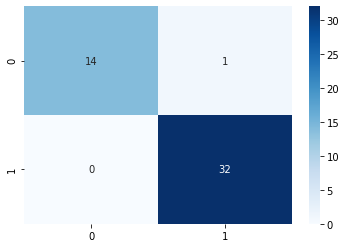

In [116]:
model_evaluate(xgb_model, X,y, y_predict_xgb)

###  Finding The Best Parameters (Hyperparameter Tuning)

In [117]:
xgb_params = {
        'subsample': [0.5, 0.75, 1], # Subsampling ratio of original dataset.
        'colsample_bytree': [0.5, 0.75, 1], # Feature subsampling ratio per tree.
        'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3], # learning rate.
        'max_depth':[2, 3, 5, 7], # Maximum depth of a tree.
        'min_child_weight':[0.5, 1, 2], # Minimum weight of a child node.
        'gamma': [0, 0.1, 0.2, 0.3, 0.5, 1.0, 2], # Regularization parameter.
        'n_estimators': [100, 200, 300, 500],  # Number of estimators in the ensemble.
        }

In [ ]:
xgboost_model = XGBClassifier()

best_parameters_xgboost = hyperparameter_tuning(X=X, y=y, estimator=xgboost_model, parameters=xgb_params, n_splits=5)
best_parameters_xgboost

Fitting 5 folds for each of 23040 candidates, totalling 115200 fits


Best parameter for penalty = l2

### Fit & Predict

In [41]:
# Fit and predict the model (predictions are made on test data)
tuned_model_logistic_regression =  LogisticRegression(solver="liblinear", penalty="l2", random_state=3)
y_test_predict_lr = model_fit_predict(tuned_model_logistic_regression)

### Evaluate The Performance

Accuracy score:  0.80 
F1-score:  0.73 

Confusion Matrix: 


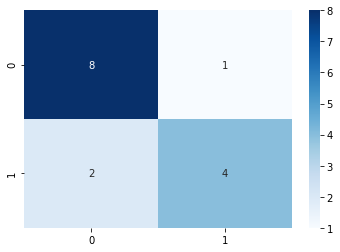

In [47]:
# Evaluate the model on test data
evaluate_logistic_regression = model_evaluate(y_test, y_test_predict_lr)

- A

- 8 of the actual positive instances are correctly classified as positive, 2 of the actual negative instances are correctly classified as negative. 3 of the actual positive instances are incorrectly classified as negative and 2 of the actual negative instances is incorrectly classified as positive.

Logistic regression tuned model have nearly 75% true positive rate (Sensitivity) and 50% false positive rate (1-Specificity), area under curve is calculated as 0.61.

###  Cross Validated Performance of XGBoost Model

* F1 score and is selected as general perofrmance evaluation metric.
* Due to the limited number of observations and imbalanced distribution of classes, accuracy score may not be meaningful for evaluating the model.

In [ ]:
# General performance of model
general_score_logistic_regression = model_general_performance(tuned_model_logistic_regression, "Logistic Regression")

## 2. Logistic Regression

* Logistic regression turns linear predictions into probabilities by using the logistic function. 
* Logistic Regression does not really have any critical hyperparameters to tune. Therefore Grid Search part is not applied to this algorithm.

### Fit & Predict 

In [ ]:
lr_model = LogisticRegression()

y_predict_lr = fit_predict(X, y, lr_model)

### Evaluate The Performance 

In [ ]:
# Evaluate the perofrmance of model on test data
model_evaluate(y, y_predict_lr)

9 of the actual positive instances are correctly classified as positive, 1 of the instances are correctly classified as negative. 3 of the  instances is incorrectly classified as positive and 2 of the poitive instances is incorrectly classified as negative. 

### Cross Validated Performance of Logistic Regression Model

In [ ]:
# General performance of the model
general_score_svc = model_general_performance(tuned_model_svc, "Support Vector Classifier")

* This confidence interval is tighter when compared to the logistic regression model.

## 3. Random Forest

Random forest classifier creates a set of decision trees from randomly selected subset of training set. It is recommended to use bootstrap samples. In sklearn, RandomForestClassifier() provides to use bootstrap samples when building trees. In random forest classifier, tuned parameters is selected as max_depth of the tree, max_features: the number of features to consider when looking for the best split, n_estimators: the number of trees in the forest, min_samples_split: the minimum number of samples required to split an internal node. Their values are selected arbitrarily.

### Hyperparameter Tuning

In [ ]:
random_forest = RandomForestClassifier(bootstrap=True, random_state=5)

parameters_random_forest = {"max_depth": [2, 5, 8, 10],
                            "criterion" : ["gini", "entropy"],
                            "n_estimators": [10, 500, 1000],
                            "min_samples_split": [2, 5, 10]}

best_parameters_random_forest = find_best_parameters(random_forest, parameters_random_forest)

In [ ]:
best_parameters_random_forest

Hyperparameters are optimized and the best parameters were selected as “1000” estimator, “entropy” criterion, “5” maximum depth, “10” minimum sample splits. The model is fitted using this hyperparameters on the training data and predictions are made on the test data. 

### Fit & Predict

In [ ]:
# Fit and predict the model

tuned_model_random_forest = RandomForestClassifier(max_depth=2,
                                                   criterion='entropy', 
                                                   min_samples_split=2,
                                                   n_estimators=1000,
                                                   random_state=5)

y_test_predict_rf = model_fit_predict(tuned_model_random_forest)

### Evaluate The Performance

In [ ]:
# Evaluate the perofrmance of model on test data
evaluate_rf = model_evaluate(y_test, y_test_predict_rf)

8 of the actual positive instances are correctly classified as positive, 3 of the instances is correctly classified as negative. 1 of the instances are incorrectly classified as positive and 3 of the instances are incorrectly classified as negative. 

In [ ]:
# Plot ROC curve
plot_roc_curve(y_test, y_test_predict_rf, 'Random Forest ROC Curve')

### General Performance- F1 Score

In [ ]:
# General perofrmance of the model
general_score_random_forest = model_general_performance(tuned_model_random_forest, "Random Forest")

## 4. k-Nearest Neighbor Classifier

K nearest neighbors is a simple algorithm that classifies based on a distance function. In this study, different k number of neighbor values and different distance functions were tried for the hyperparameter tuning. Number of neighbors considered 1 to 8 and  p(distance)  values of 1 (Manhattan), 2 (Euclidean), and 5 (Minkowski) are tried to find best parameter with repeated 5-fold cross validation on training data.

### Hyperparameter Tuning

In [ ]:
kNN = KNeighborsClassifier()
parameters_kNN = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8], 
                  'p': [1, 2, 5]}

best_parameters_kNN = find_best_parameters(kNN, parameters_kNN)

In [ ]:
best_parameters_kNN

### Fit & Predict

In [ ]:
# Fit and predict the model (predictions are made on test data)
tuned_model_kNN = KNeighborsClassifier(n_neighbors=3, p=5)
y_test_predict_kNN = model_fit_predict(tuned_model_kNN)

- Hyperparameters are optimized and the best parameters are selected as k=7, p = 2. The model is fitted using this hyperparameter on the training data and predictions are made on the test. 

### Evaluate The Performance

In [ ]:
# Evaluate the perofrmance of model on test data
evaluate_kNN = model_evaluate(y_test, y_test_predict_kNN)

- 7 of the actual positive instances are correctly classified as positive, 1 of the instances is correctly classified as negative. 3 of the instances are incorrectly classified as positive and 4 of the instances are incorrectly classified as negative.

In [ ]:
# Plot ROC curve
plot_roc_curve(y_test, y_test_predict_kNN, 'KNN ROC Curve')

- This model has nearly 75% false positive rate.  Also, area under curve is calculated as 0.44. It can be said that k-nearest neighbor algorithm does not perform well.

### General Performance-F1 Score

In [ ]:
# General perofrmance of the model
general_score_kNN = model_general_performance(tuned_model_kNN, "k-Nearest Neighbor Classifier")

# Final Evaluation

In [ ]:
def make_dataframe_final_results(models):
    
    results_ = []
    names_ = []
    for model in models:
        names = model.__class__.__name__
        cv_method = RepeatedKFold(n_splits=5, n_repeats=10, random_state=0)
        cv_results = cross_val_score(model, X=X, y=y, cv=cv_method, scoring='f1')
        results_.append(cv_results)
        names_.append(names)


    f1_scores = np.transpose(results_)
    final_df = pd.DataFrame(f1_scores, columns = names_)
    final_df = pd.melt(final_df)
    final_df.columns = ["Classifier", "F1-score"]
    return final_df

In [ ]:
models = [tuned_model_logistic_regression,
         tuned_model_svc,
         tuned_model_random_forest,
         tuned_model_kNN]
results = make_dataframe_final_results(models)

In [ ]:
# Bar chart of the F1 score of models
sns.catplot(
    data=results, kind="bar",
    x="F1-score", y="Classifier",
    ci="sd", palette="tab20_r", alpha=.6, height=6)

In [ ]:
# Box plot of models
results = make_dataframe_final_results(models)
sns.boxplot(x="F1-score" , y="Classifier", data=results, palette="Paired");

*  Support vector machine, Logistic regression and random forest have nearly same performance, k-Nearest Neighbors is out performed by other three model.

## References 


Banerjee, P. (2020, March 13). KNN Classifier Tutorial in Python. Kaggle. https://www.kaggle.com/prashant111/knn-classifier-tutorial

Cross Validation (2019) Retrieved May 31,2020, from https://scikit-learn.org/stable/modules/cross_validation.html


Grid Search Cross Validation. (2019). Retrieved May 31, 2020, from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Logistic Regression (2019) Retrieved May 31, 2020, from https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Kumar, D. (2020, May 28). Covid-19 Analysis, Visualization & Comparisons. Kaggle. https://www.kaggle.com/imdevskp/covid-19-analysis-visualization-comparisons

Model Evaluation (2019) Retrieved May 31, 2020, from https://scikit-learn.org/stable/modules/model_evaluation.html

Model Validation in Python. (2018, June 19). Retrieved May 2, 2020, from https://www.datavedas.com/model-validation-in-python/

Random Forest Classifier (2019) Retrieved May 31, 2020, from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Receiver Operating Characteristic (ROC) (2019) Retrived May 31, 2020, from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

SVM Hyperparameter Tuning Using GridSearcCV. (n.d.). Retrieved May 31, 2020, from https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/